In [ ]:
#やること; utilsを小分けに。出力の頻度とかは妥当?

In [14]:
#!unzip Data_rareplanes_10_20_2020.zip

In [1]:
!pip install torch==1.0.1
!pip install torchvision==0.2.1

In [14]:
# フォルダ「weights」が存在しない場合は作成する
weights_dir = "./weights/"
if not os.path.exists(weights_dir):
    os.mkdir(weights_dir)

In [7]:
# 学習済みのSSD用のVGGのパラメータをフォルダ「weights」にダウンロード
# MIT License
# Copyright (c) 2017 Max deGroot, Ellis Brown
# https://github.com/amdegroot/ssd.pytorch
    
url = "https://s3.amazonaws.com/amdegroot-models/vgg16_reducedfc.pth"
target_path = os.path.join(weights_dir, "vgg16_reducedfc.pth") 

if not os.path.exists(target_path):
    urllib.request.urlretrieve(url, target_path)

In [1]:
#必要なライブラリをインストール

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import sys
import time 
import pandas as pd
import urllib.request
import zipfile
import tarfile
import cv2
import random
import xml.etree.ElementTree as ET
from math import sqrt
from glob import glob
from itertools import product


import torch
import torch.utils.data as data
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
from torch.autograd import Function
from utils.augmentations import Compose, ConvertFromInts, ToAbsoluteCoords, PhotometricDistort, Expand, RandomSampleCrop, RandomMirror, ToPercentCoords, Resize, SubtractMeans
from utils.dataloader import RareplaneDataset, DataTransform, xml_to_list, od_collate_fn, get_color_mean


In [2]:
print(torch.__version__)
print(torchvision.__version__)

1.0.1
0.2.1


In [3]:
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

In [4]:
# Training画像とそのアノテーション、またValidation画像とそのアノテーションをそれぞれリストにする。

train_image_dir = './Data_rareplanes/train/images/'
train_img_paths = glob(os.path.join(train_image_dir, '*.png'))

val_image_dir = './Data_rareplanes/val/images/'
val_img_paths = glob(os.path.join(val_image_dir, '*.png'))

train_label_paths = [train_img_paths[i].replace('png', 'xml',1).replace('images','labels',1) for i in range(len(train_img_paths))]
val_label_paths = [val_img_paths[i].replace('png', 'xml',1).replace('images','labels',1) for i in range(len(val_img_paths))]

my_classes = ["airplane"]

In [5]:
color_mean = get_color_mean(train_img_paths)
print(color_mean)

(143.1487009512939, 136.12215208212658, 134.96655592553213)


In [6]:
#color_mean = (104, 117, 223) # (BGR) mean.
input_size = 300

train_dataset = RareplaneDataset(train_img_paths, train_label_paths, phase = 'train', 
                                transform = DataTransform(input_size, color_mean),
                                transform_anno = xml_to_list(my_classes)
                                )

val_dataset = RareplaneDataset(val_img_paths, val_label_paths, phase = 'val', 
                                transform = DataTransform(input_size, color_mean),
                                transform_anno = xml_to_list(my_classes)
                                )

In [7]:
batch_size = 32 # 4
# 32, 8 よりは64の方が収束が早そう。

train_dataloader = data.DataLoader(
    train_dataset, batch_size = batch_size, shuffle = True, collate_fn = od_collate_fn
)

val_dataloader = data.DataLoader(
    val_dataset, batch_size = batch_size, shuffle = True, collate_fn = od_collate_fn
)

dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

In [ ]:
#学習済みモデルのダウンロード
url = "https://s3.amazonaws.com/amdegroot-models/vgg16_reducedfc.pth"
target_path = os.path.join(./weights, "vgg16_reducedfc.pth") 

if not os.path.exists(target_path):
    urllib.request.urlretrieve(url, target_path)

In [8]:
from utils.ssd_model import SSD

ssd_cfg = {
    'num_classes': 2, # 背景を含む
    'input_size': 300, 
    'bbox_aspect_num': [4,6,6,6,4,4],
    'feature_maps': [38,19,10,5,3,1],
    'steps': [8,16,32,64,100,300], # DBoxの大きさ (なぜ)
    'min_sizes': [30,60,111,162,213,264],
    'max_sizes': [60,111,162,213,264,315],
    'aspect_ratios': [[2],[2,3],[2,3],[2,3],[2],[2]]
}

net = SSD(phase='train', cfg = ssd_cfg)

vgg_weights = torch.load('./weights/vgg16_reducedfc.pth')
net.vgg.load_state_dict(vgg_weights)

def weights_init(m):
    if isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight.data)
        if m.bias is not None:
            nn.init.constant_(m.bias,0.0)
            
net.extras.apply(weights_init)
net.loc.apply(weights_init)
net.conf.apply(weights_init)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("使用Device:", device)

print("ネットワーク設定完了。学習済みの重みパラメータをロード完了。")

使用Device: cpu
ネットワーク設定完了。学習済みの重みパラメータをロード完了。


In [9]:
from utils.loss import MultiBoxLoss

criterion = MultiBoxLoss(jaccard_thresh=0.5, neg_pos = 3, device=device)

optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
#optim.SGD(net.parameters(), lr=1e-3,momentum=0.9, weight_decay = 5e-4)

In [2]:
def train_model(net,dataloaders_dict, criterion, optimizer, num_epochs):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用Device:", device)
    
    net.to(device)
        
    torch.backends.cudnn.benchmark = True
    
    iteration = 1
    epoch_train_loss = 0.0
    epoch_val_loss = 0.0
    logs = []
    
    #学習開始
    for epoch in range(num_epochs+1):
        t_epoch_start = time.time()
        t_iter_start = time.time()
    
        print('------------')
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('------------')
     
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()
                print(' (train) ')
        
            else:
                if ((epoch+1) % 10 == 0):
                    net.eval()
                    print('----------')
                    print(' (val) ')
                    
                else:
                    continue
                    
            for images, targets in dataloaders_dict[phase]:
                images = images.to(device)
                targets = [ann.to(device)
                            for ann in targets]
                    
                optimizer.zero_grad()
                    
                with torch.set_grad_enabled(phase=='train'):
                    outputs = net(images)
                    
                    #損失関数は、バウンディングボックスの位置の予測に関するもの(=loss_l)と分類予測に関するもの(=loss_c)の和になる。
                    loss_l, loss_c = criterion(outputs, targets)
                    loss = loss_l + loss_c
                    
                    if phase == 'train':
                        loss.backward()
                            
                        nn.utils.clip_grad_value_(
                            net.parameters(), clip_value = 2.0
                            )
                            
                        optimizer.step()
                            
                        if (iteration % 2 ==0):
                            t_iter_finish = time.time()
                            duration = t_iter_finish - t_iter_start
                            print('イテレーション {} || Loss: {:.4f} || 10iter:{:.4f} sec.'.format(
                            iteration, loss.item(), duration))
                            t_iter_start = time.time()
                            
                        epoch_train_loss += loss.item()
                        iteration += 1
                        
                    else:
                        epoch_val_loss += loss.item()
                                
                                
        t_epoch_finish = time.time()
        print('------------')
        print('epoch {} || Epoch_TRAIN_Loss:{:.4f} || Epoch_VAL_Loss:{:.4f}'.format(
        epoch+1, epoch_train_loss, epoch_val_loss))
        
        print('timer: {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()
        
        log_epoch = {'epoch': epoch+1, 'train_loss': epoch_train_loss, 'val_loss': epoch_val_loss}
        logs.append(log_epoch)
        df = pd.DataFrame(logs)
        df.to_csv("log_output.csv")
        
        epoch_train_loss = 0.0
        epoch_val_loss = 0.0
        
        #10エポックごとに重みを保存する。
        if ((epoch+1)%10 ==0):
            torch.save(net.state_dict(),'weights/SSD300_'+str(epoch+1)+'.pth')

In [13]:
num_epochs = 200  

train_model(net, dataloaders_dict, criterion, optimizer, num_epochs = num_epochs)

使用Device: cpu
------------
Epoch 1/200
------------
 (train) 
イテレーション 2 || Loss: 3509.4802 || 10iter:52.2317 sec.
イテレーション 4 || Loss: 99.7308 || 10iter:53.4657 sec.
イテレーション 6 || Loss: 17.1309 || 10iter:51.2001 sec.
イテレーション 8 || Loss: 30.4145 || 10iter:52.1168 sec.
イテレーション 10 || Loss: 15.8940 || 10iter:52.4673 sec.
イテレーション 12 || Loss: 10.5187 || 10iter:52.4800 sec.
イテレーション 14 || Loss: 9.1825 || 10iter:46.5551 sec.
------------
epoch 1 || Epoch_TRAIN_Loss:3818.9820 || Epoch_VAL_Loss:0.0000
timer: 360.5179 sec.
------------
Epoch 2/200
------------
 (train) 
イテレーション 16 || Loss: 8.4894 || 10iter:50.7820 sec.
イテレーション 18 || Loss: 9.5939 || 10iter:52.7780 sec.
イテレーション 20 || Loss: 8.3788 || 10iter:51.7519 sec.
イテレーション 22 || Loss: 7.6823 || 10iter:51.6342 sec.
イテレーション 24 || Loss: 8.8041 || 10iter:53.1936 sec.
イテレーション 26 || Loss: 8.2590 || 10iter:51.6476 sec.
イテレーション 28 || Loss: 7.6393 || 10iter:48.0766 sec.
------------
epoch 2 || Epoch_TRAIN_Loss:117.6706 || Epoch_VAL_Loss:0.0000
timer: 359.866

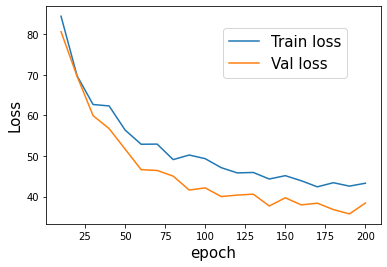

In [103]:
#損失関数のプロット

log_data = pd.read_csv("log_output.csv")
#エポック10ごとに切り出す
log_data_10 = log_data[log_data["epoch"] % 10 == 0]

plt.xlabel("epoch", fontsize= 15)
plt.ylabel("Loss", fontsize= 15)

plt.plot(log_data_10["epoch"],log_data_10["train_loss"], label="Train loss")
plt.plot(log_data_10["epoch"],log_data_10["val_loss"], label="Val loss")

plt.legend(bbox_to_anchor=(0.9, 0.9), loc='upper right', borderaxespad=0, fontsize=15)
plt.show()

In [3]:
from utils.ssd_model import SSD

my_classes = ["airplane"]


ssd_cfg = {
    'num_classes': 2, # 背景を含む
    'input_size': 300, 
    'bbox_aspect_num': [4,6,6,6,4,4],
    'feature_maps': [38,19,10,5,3,1],
    'steps': [8,16,32,64,100,300], # DBoxの大きさ (なぜ)
    'min_sizes': [30,60,111,162,213,264],
    'max_sizes': [60,111,162,213,264,315],
    'aspect_ratios': [[2],[2,3],[2,3],[2,3],[2],[2]]
}

net = SSD(phase='inference', cfg = ssd_cfg)

net_weights = torch.load('./weights/SSD300_200.pth', map_location={'cuda:0': 'cpu'})
# torch.load('./weights/ssd300_12.pth', map_location={'cuda:0': 'cpu'})
net.load_state_dict(net_weights)

print("ネットワーク設定完了。学習済みの重みパラメータをロード完了。")

FileNotFoundError: [Errno 2] No such file or directory: './weights/SSD300_200.pth'

In [12]:
test_image_dir = './Data_rareplanes/test/images/'
test_img_paths = glob(os.path.join(test_image_dir, '*.png'))

'/home/jovyan/work/Airplane_detect'

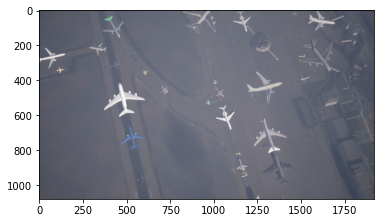

torch.Size([3, 300, 300])


In [19]:
img_file_path = test_img_paths[1]
img = cv2.imread(img_file_path)
height, width, channels = img.shape

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

#color_mean = (104,117,123)
input_size = 300
transform = DataTransform(input_size, color_mean)

phase = 'val'
img_transformed, boxes, labels = transform(img, phase, "", "")
img = torch.from_numpy(img_transformed[:,:,(2,1,0)]).permute(2,0,1)
 
#plt.imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB)) ##
#plt.show() ##
print(img.shape)

net.eval()
x = img.unsqueeze(0)
#print(x.shape)

detections = net(x)

#print(type(detections))
#print(detections.shape)
#print(detections[detections != 0])

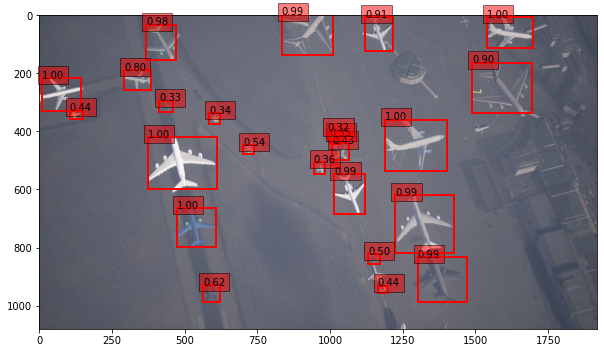

In [20]:
from utils.ssd_predict_show import SSDPredictShow 

#img_file_path = "./Narita_airport_ASNARO1_zoom17.png"
ssd = SSDPredictShow(color_mean, eval_categories = my_classes, net = net)
ssd.show(img_file_path, data_confidence_level=0.3)

In [ ]:
#ASNARO1の画像をダウンロード
import requests
from skimage import io
from io import BytesIO
%matplotlib inline
TOKEN = "b5d88b02-7802-4336-b570-eab2521d3766"

def get_combined_image(get_image_func, z, topleft_x, topleft_y, size_x=1, size_y=1, option={}, params={}):
    rows = []
    blank = np.zeros((256, 256, 4), dtype=np.uint8)
    
    for y in range(size_y):
        row = []
        for x in range(size_x):
            try:
                img = get_image_func(z, topleft_x + x, topleft_y + y, option, params)
            except Exception as e:
                img = blank
                
            row.append(img)
        rows.append(np.hstack(row))
    return  np.vstack(rows)

def get_asnaro1_image(z, x, y, option, params={}):
    url = 'https://gisapi.tellusxdp.com/ASNARO-1/{}/{}/{}/{}.png'.format(option['entityId'], z, x, y)
    headers = {
        'Authorization': 'Bearer ' + TOKEN
    }
    r = requests.get(url, headers=headers, params=params)
    if not r.status_code == requests.codes.ok:
        r.raise_for_status()
    return io.imread(BytesIO(r.content))    

option = {
    'entityId': '20190110093424839_AS1' # 成田国際空港が写っているシーン
}
z = 17       # ズーム率
x = 116650    # 起点となるタイルのx座標
y  = 51570  # 起点となるタイルのy座標

#起点となるタイルから3×3枚のタイルを結合
combined = get_combined_image(get_asnaro1_image, z, x, y, 3, 3, option)

#io.imshow(combined)
io.imsave('./Narita_airport_ASNARO1_zoom17.png', combined)

In [10]:
################  以下はAppendix ###################

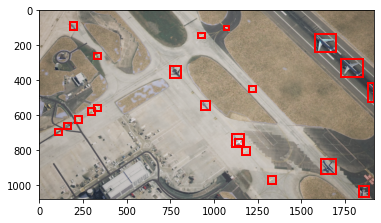

In [9]:

### 試しにアノテーションを表示 ###

N_show=15

image_file_path = train_img_paths[N_show]
img = cv2.imread(image_file_path)
H, W, channels = img.shape

plt.imshow(img[:,:,::-1])

# 今操作したいaxis（画像）を選択
current_axis = plt.gca()
transform_anno = xml_to_list(my_classes)
anno_list = transform_anno(train_label_paths[N_show],W,H)

for item in anno_list:
    # バウンディングボックスの座標から始点と幅、高さを算出し、四角形を生成
    xmin = item[0]*W
    ymin = item[1]*H
    width = (item[2]-item[0])*W
    height = (item[3]-item[1])*H
    rect = plt.Rectangle((xmin, ymin), width, height, color="r", fill=False, linewidth=2)
    
    current_axis.add_patch(rect)  

plt.show()

'/home/jovyan/work/Airplane_detect'

In [75]:
!git init

Reinitialized existing Git repository in /home/jovyan/work/Airplane_detect/.git/


In [76]:
!git remote -v

In [77]:
!git remote add origin https://github.com/ryomaouchi/Airplane_detection.git

In [64]:
#!git remote set-url origin git@github.com:ryomaouchi/Airplane_detection.git

In [ ]:
https://github.com/ryomaouchi/Airplane_detect_sorabatake.git #nya

In [78]:
!git config user.email "pandanmt1@gmail.com"

In [79]:
!git config user.name "ryomaouchi"

In [86]:
!git add *

In [87]:
!git commit -m "First commit"

[master 8169cf9] First commit
 3 files changed, 45 insertions(+), 29 deletions(-)
 delete mode 100644 weights/SSD300_200.pth
 delete mode 100644 weights/vgg16_reducedfc.pth


In [46]:
username = "ryomaouchi"
#print("ryomaouchi")

In [83]:
#!git push origin master
!git push https://ryomaouchi@github.com/ryomaouchi/Airplane_detection.git master
          https://github.com/ryomaouchi/Airplane_detection.git

UnboundLocalError: local variable 'child' referenced before assignment

In [84]:
!git push https://ryomaouchi@github.com/ryomaouchi/Airplane_detection.git master

Password for 'https://ryomaouchi@github.com': 

In [74]:
!git remote rm origin

In [2]:
pwd

'/home/jovyan/work/Airplane_detect'